Modifications:

1. Created a Spark Session
2. Replaced 'monthly' with 'weekly' everywhere
3. used num_weeks in place of num_months

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create a Spark Session
from pyspark.sql.session import SparkSession

spark = SparkSession.builder.getOrCreate()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import time
import os
import pickle
import sklearn

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def r_squared_train(y_test, y_pred, y_train):
    rss = 0
    tss = 0
    mean = sum(y_train)/len(y_train)
    for i in range(len(y_test)):
        rss = rss + np.square(y_test[i] - y_pred[i])
        tss = tss + np.square(y_test[i] - mean)
    r_square = 1 - (rss/tss)
    return r_square

In [4]:
revenue_weekly = spark.read.option("header",True).csv("/content/RevenueSince2017Weekly.csv")

In [5]:
display(revenue_weekly)

DataFrame[Year: string, Week: string, Revenue: string, Volume: string]

In [6]:
lob = 'Total'

In [7]:
revenue_weekly_df = revenue_weekly.toPandas()

In [8]:
revenue_weekly_df['Year'] = revenue_weekly_df['Year'].astype(int)
revenue_weekly_df['Week'] = revenue_weekly_df['Week'].astype(int)
revenue_weekly_df['Revenue'] = revenue_weekly_df['Revenue'].astype(float)
num_weeks = len(revenue_weekly_df)

In [9]:
display(revenue_weekly_df)

,Year,Week,Revenue,Volume
0,2017,1,1494.762,13
1,2017,2,3155.840,12
2,2017,3,14501.530,43
3,2017,4,10780.378,58
4,2017,5,13961.837,68
...,...,...,...,...
274,2022,13,581314.822,3950
275,2022,14,557168.606,3456
276,2022,15,482892.386,2825
277,2022,16,442427.949,2769


**Modification**:

added 'week' (instead of 'month') as an arg below

In [10]:
def Insert_row_(row_number, df, year, week):
    df1 = df[0:row_number]
    df2 = df[row_number:]
    df1.loc[row_number]=[year, week, 0]
    df_result = pd.concat([df1, df2])
    df_result.index = [*range(df_result.shape[0])]
    return df_result

**Modification:**

1. count = 52


In [11]:
start_year = revenue_weekly_df.iloc[0,1]
start_week = revenue_weekly_df.iloc[0,2]
count = 1
for i in range(1,num_weeks):

    if count == 52:
        start_year = start_year + 1
        start_week = 0
        count = 0
    if ((start_year == revenue_weekly_df.iloc[i,0]) and ((start_week + 1) != revenue_weekly_df.iloc[i,1])):
        revenue_weekly_df = Insert_row_(i, revenue_weekly_df, start_year, start_week + 1)
    start_week = start_week + 1
    count = count + 1

In [12]:
display(revenue_weekly_df)


,Year,Week,Revenue,Volume
0,2017,1,1494.762,13
1,2017,2,3155.840,12
2,2017,3,14501.530,43
3,2017,4,10780.378,58
4,2017,5,13961.837,68
...,...,...,...,...
274,2022,13,581314.822,3950
275,2022,14,557168.606,3456
276,2022,15,482892.386,2825
277,2022,16,442427.949,2769


In [13]:
print(revenue_weekly_df.dtypes)

Year         int64
Week         int64
Revenue    float64
Volume      object
dtype: object


In [14]:
X = revenue_weekly_df['Revenue'].values
x_axis_labels = []
for i in range(num_weeks):
    if revenue_weekly_df.iloc[i,1] == 1:
        x_axis_labels.append(str(revenue_weekly_df.iloc[i,0]))
    else:
        x_axis_labels.append(' ')

In [15]:
for i in range(len(revenue_weekly_df)):
    if revenue_weekly_df.iloc[i,0] == 2022 and revenue_weekly_df.iloc[i,1] == 1:
        size = i
print(size)

262


In [16]:
print(size)
print(num_weeks)


262
279


In [17]:
train = X[0:size]
test = X[size:num_weeks+1]
print(train)
print(test)

[  1494.762   3155.84   14501.53   10780.378  13961.837  25163.07
  19972.817  17382.296  23816.224  24582.266  20369.63   30358.911
  17112.118  14081.062  19702.096  17033.784  16142.014  10473.603
  25583.261  22974.166  30444.695  22155.655  41760.061  31514.365
  23902.541  28401.262  25058.535  23199.434  18883.56   32461.399
  33241.036  25233.55   27174.301  27643.899  23906.938  21083.225
  25387.318  34226.956  43813.508  38395.986  35132.549  30218.064
  37368.037  46694.504  46991.649  37679.79   36704.268  38468.654
  38482.884  41199.26   27101.626  15250.794  29967.323  23968.077
  35439.866  63213.22   73466.753 107433.88   86273.347 117785.052
 105382.565 115219.75  125856.448 113355.341 142281.213 105331.888
  93110.021  95130.174 120187.566  81604.239  90942.153  99432.885
  96381.354 112416.7   108974.715 114839.508 107185.529 122930.085
 155092.148 175075.813  98820.04  119048.027 129712.976 150759.699
 130750.889  78625.325 109835.819 126875.827 123294.064 120120.

In [18]:
history = [x for x in train]
predictions = list()
confidence_lower = list()
confidence_upper = list()
revenue_weekly_df['Date'] = revenue_weekly_df['Year'].map(str) + '-' + revenue_weekly_df['Week'].map(str)
dates_train = revenue_weekly_df['Date'][0:size].values
dates_test = revenue_weekly_df['Date'][size:num_weeks+1].values

In [19]:
print(history)
print(test)
print(dates_train)
print(dates_test)

[1494.762, 3155.84, 14501.53, 10780.378, 13961.837, 25163.07, 19972.817, 17382.296, 23816.224, 24582.266, 20369.63, 30358.911, 17112.118, 14081.062, 19702.096, 17033.784, 16142.014, 10473.603, 25583.261, 22974.166, 30444.695, 22155.655, 41760.061, 31514.365, 23902.541, 28401.262, 25058.535, 23199.434, 18883.56, 32461.399, 33241.036, 25233.55, 27174.301, 27643.899, 23906.938, 21083.225, 25387.318, 34226.956, 43813.508, 38395.986, 35132.549, 30218.064, 37368.037, 46694.504, 46991.649, 37679.79, 36704.268, 38468.654, 38482.884, 41199.26, 27101.626, 15250.794, 29967.323, 23968.077, 35439.866, 63213.22, 73466.753, 107433.88, 86273.347, 117785.052, 105382.565, 115219.75, 125856.448, 113355.341, 142281.213, 105331.888, 93110.021, 95130.174, 120187.566, 81604.239, 90942.153, 99432.885, 96381.354, 112416.7, 108974.715, 114839.508, 107185.529, 122930.085, 155092.148, 175075.813, 98820.04, 119048.027, 129712.976, 150759.699, 130750.889, 78625.325, 109835.819, 126875.827, 123294.064, 120120.334, 1

**Modifications:**

1. last parameter in seasonal order is 52 because it is weekly data

In [20]:
for t in range(len(test)):
        model = SARIMAX(history, order=(0,0,0), seasonal_order = (1, 1, 1, 52))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        fcast = model_fit.get_forecast()
        confidence_interval = fcast.conf_int(alpha=0.05)
        yhat = output[0]
        yhat = max(0, yhat)
        confidence_lower.append(max(0,(int(confidence_interval[:,0][0]))))
        confidence_upper.append(int(confidence_interval[:,1][0]))
        predictions.append(int(yhat))
        obs = test[t]
        history.append(yhat)
        #print('month=%s, predicted=%d, expected=%d, min conf=%d, max conf=%d' % (dates_test[t],yhat, obs, confidence_lower[t], confidence_upper[t]))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %d' % rmse)
r_squared = r2_score(test, predictions)
print('Test R-squared: %.2f' % r_squared)
mae = mean_absolute_error(test, predictions)
print('Test MAE: %d' % mae)
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(test, predictions)
rev = revenue_weekly_df["Revenue"]
max_revenue = rev.max()
avg_revenue = rev.mean()
standardized_avg_mae = mae/avg_revenue
standardized_avg_rmse = rmse/avg_revenue
standardized_max_mae = mae/max_revenue
standardized_max_rmse = rmse/max_revenue


Test RMSE: 145060
Test R-squared: -0.59
Test MAE: 119790


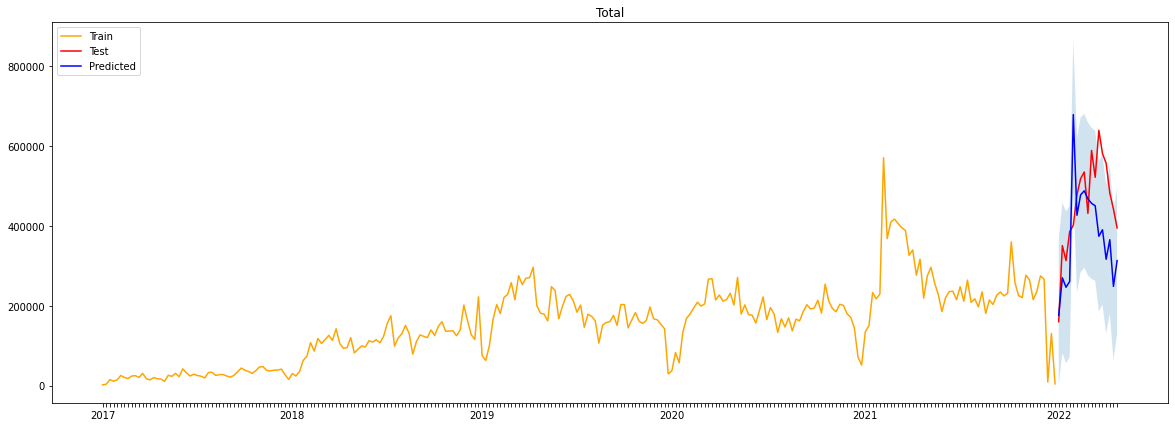

In [21]:
# plot forecasts against actual outcomes
pyplot.figure(figsize=(20, 7))
pyplot.title(lob)
pyplot.plot(dates_train, train, color = 'orange', label="Train")
pyplot.plot(dates_test, test, color = 'red', label="Test")
pyplot.plot(dates_test, predictions, color = 'blue', label="Predicted")
pyplot.legend(loc="upper left")
pyplot.fill_between(dates_test, confidence_upper , confidence_lower , alpha=.2)
pyplot.xticks(np.arange(len(x_axis_labels)),x_axis_labels)
pyplot.show()